In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

In [17]:
from helper__3stays_v3_scripts import switch_indices

In [16]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots

In [23]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [20]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
#print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
#print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
#print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

# Start here

In [14]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
#from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
#from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [10]:
from synthetic_data.canonical_stays import get3e, get3

In [18]:
from helper__get_clusters import get_clusters_1, get_clusters_2, get_clusters_3, get_clusters_4

In [8]:
time_thresh = 1/6
dist_thresh=0.25

In [9]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

In [11]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.004
Dupli. frac. =  0.000


2.7688798277695947 4.88908806935414 1.322570910903968


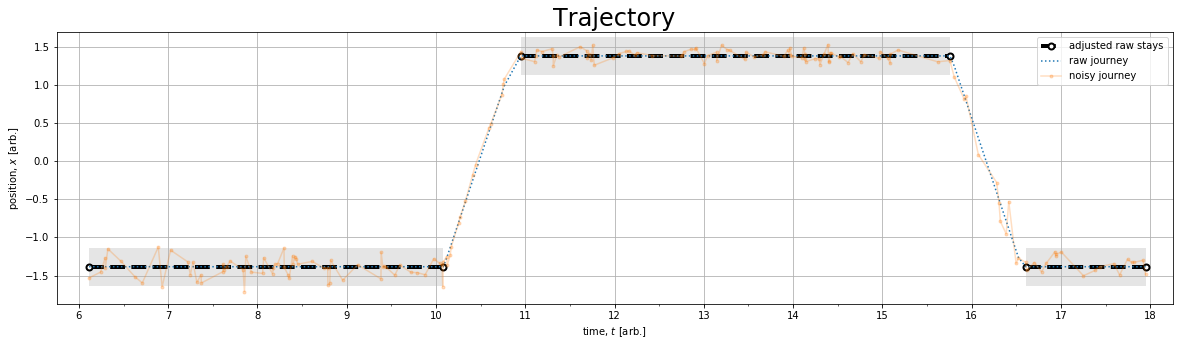

In [15]:
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 10, 10)[0]
shift = rand_range(-10, 10, 21)[0]

print(x_dist, mid_len, shift)
if np.random.randint(0,2,1):
    stays = get3e(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [21]:
verbose = True
print(time_arr.size)

if verbose: print("version 1")
clusters_1 = get_clusters_1(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_1), "Clusters:")
print_clusts(clusters_1);
print()

if verbose: print("version 2")
clusters_2 = get_clusters_2(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_2), "Clusters:")
print_clusts(clusters_2);
print()

if verbose: print("version 3")
clusters_3 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_3), "Clusters:")
print_clusts(clusters_3);
print()

if verbose: print("version 4")
clusters_4 = get_clusters_4(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_4), "Clusters:")
print_clusts(clusters_4);
print()

184
version 1
6 7 cont
10 10 cont
14 16 cont
46 48 cont
76 77 cont
76 88 cont
76 95 cont
76 102 cont
76 115 cont
76 120 cont
76 151 cont
157 157 cont
163 173 cont
18 Clusters:
[   0,   2]
[   0,   2]
[   6,   8]
[   6,   8]
[  10,  12]
[  10,  12]
[  14,  21]
[  14,  21]
[  23,  30]
[  23,  30]
[  32,  42]
[  32,  42]
[  46,  65]
[  46,  65]
[  67,  68]
[  76, 152]
[  76, 152]
[ 154, 155]

version 2
11 Clusters:
[   0,   2]
[   6,   8]
[  11,  12]
[  14,  21]
[  24,  42]
[  50,  60]
[  63,  66]
[  68,  69]
[  75,  80]
[  82, 152]
[ 163, 183]

version 3
8 Clusters:
[   0,  67]
[  68,  70]
[  71,  72]
[  73,  74]
[  75, 153]
[ 155, 156]
[ 159, 160]
[ 163, 183]

version 4
[173, 174, 175, 176, 177, 178, 179, 180, 181, 182]
5 Clusters:
[   0,  65]
[  67,  68]
[ 151, 152]
[ 154, 155]
[ 173, 182]



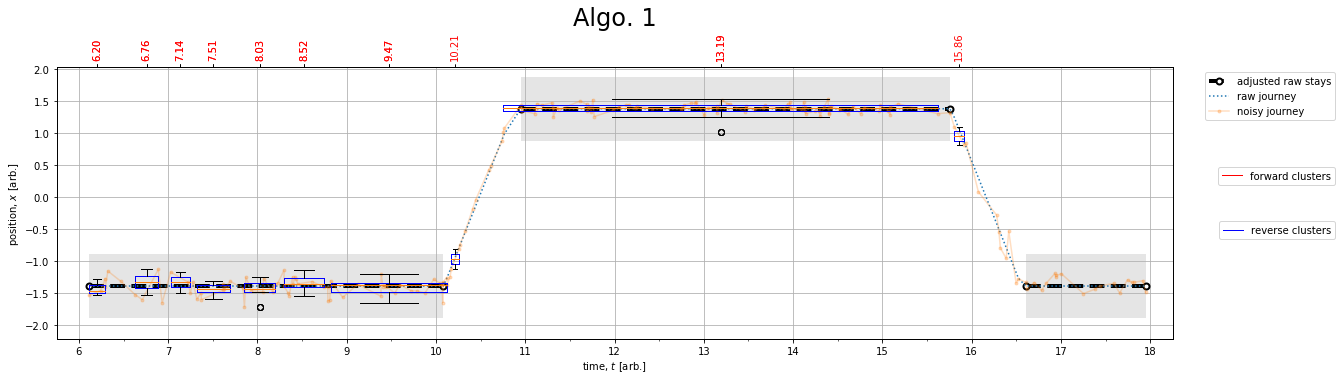

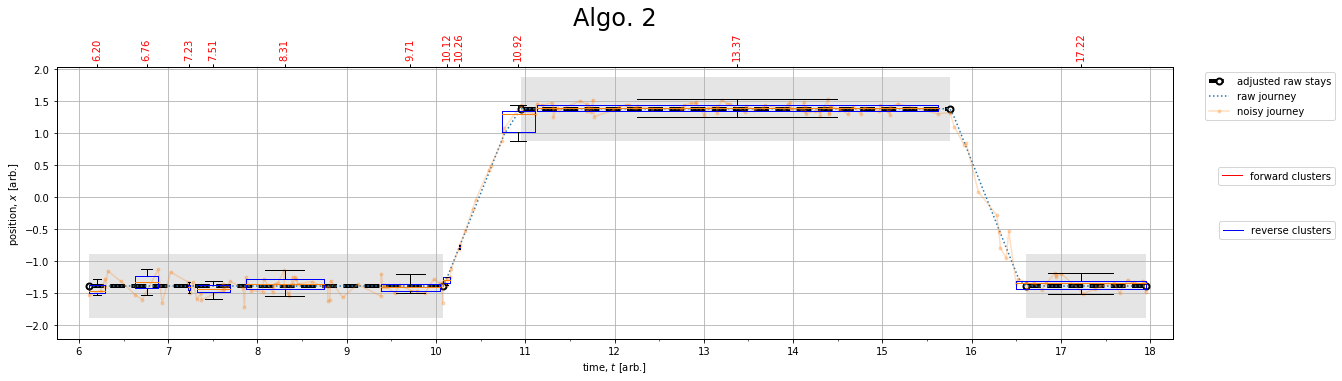

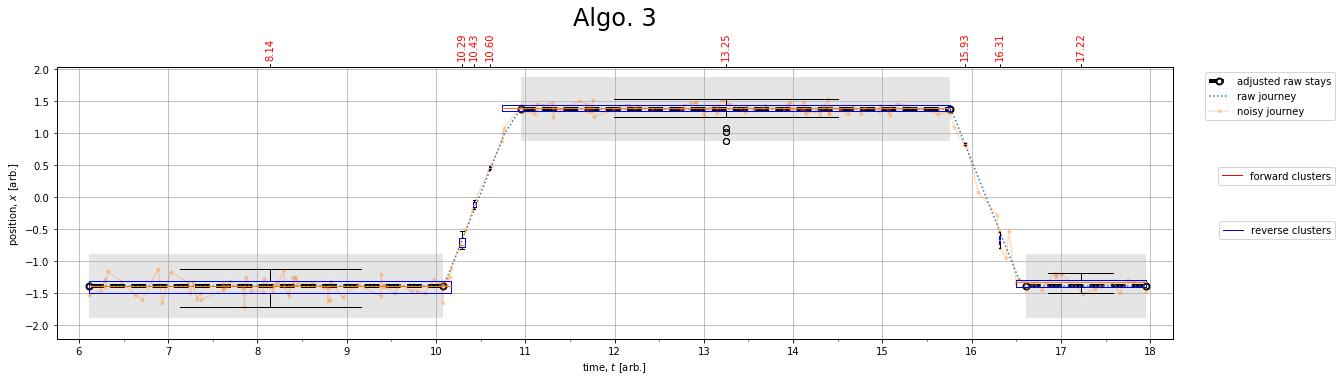

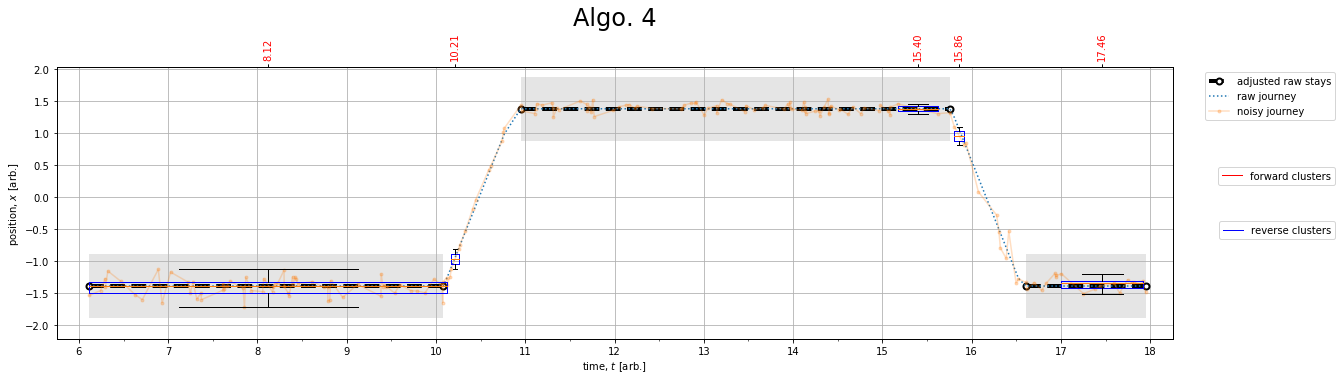

In [22]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_1, switch_indices(clusters_1, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Algo. 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_4, switch_indices(clusters_4, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 4", fontsize=24);

In [26]:
if verbose: print("version 1")
get_segments_scores(time_arr, segments, clusters_1, True);
print()

if verbose: print("version 2")
get_segments_scores(time_arr, segments, clusters_2, True);
print()

if verbose: print("version 3")
get_segments_scores(time_arr, segments, clusters_3, True);
print()

if verbose: print("version 4")
get_segments_scores(time_arr, segments, clusters_4, True);

version 1
Predicted 18 of 3 true clusters 
	Cluster   0, [   0,  63]
		overlaps with 14 pred_cluster(s):
			[   0,   2]
			[   0,   2]
			[   6,   8]
			[   6,   8]
			[  10,  12]
			[  10,  12]
			[  14,  21]
			[  14,  21]
			[  23,  30]
			[  23,  30]
			[  32,  42]
			[  32,  42]
			[  46,  65]
			[  46,  65]
			precision:  0.900;
			recall:  0.281

	Cluster   1, [  78, 153]
		overlaps with 2 pred_cluster(s):
			[  76, 152]
			[  76, 152]
			precision:  0.974;
			recall:  0.987

	Cluster   2, [ 165, 183]
		No overlap

Stats: 
	min. precision:  0.900; min. recall:  0.047
	avg. precision:  0.984; avg. recall:  0.229
	tot. precision:  0.942; tot. recall:  0.811

Durations: 
tot. trajectory duration: 11.834 
tot. true stays duration: 10.118 (0.855%) 
tot. pred stays duration: 16.189 (1.368%)

version 2
Predicted 11 of 3 true clusters 
	Cluster   0, [   0,  63]
		overlaps with 7 pred_cluster(s):
			[   0,   2]
			[   6,   8]
			[  11,  12]
			[  14,  21]
			[  24,  42]
			[  50,  60]
		


### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

In [27]:
if verbose: print("version 3")
clusters_3 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh, True)
print(len(clusters_3), "Clusters:")
print_clusts(clusters_3);
print()

version 3
	Appended: [   0,    3]
	Appended: [   4,    5]
		Merged
	Appended: [   6,    9]
		Merged
	Appended: [  10,   13]
		Merged
	Appended: [  14,   22]
		Merged
	Appended: [  24,   43]
		Merged
	Appended: [  44,   45]
		Merged
	Appended: [  47,   48]
		Merged
	Appended: [  50,   61]
		Merged
	Appended: [  63,   67]
		Merged
	Appended: [  68,   70]
	Appended: [  71,   72]
	Appended: [  73,   74]
	Appended: [  75,   81]
	Appended: [  82,  153]
		Merged
	Appended: [ 155,  156]
	Appended: [ 159,  160]
	Appending: [ 163,  183]
8 Clusters:
[   0,  67]
[  68,  70]
[  71,  72]
[  73,  74]
[  75, 153]
[ 155, 156]
[ 159, 160]
[ 163, 183]



In [28]:
from helper__metric_box__explore import get_iqr_mask

In [57]:
def get_iqr_trimmed_clusters(x_arr, clusters, iqr_factor=1.5, within=True, verbose=True):
    new_clusters = []
    for c in clusters:
        cc = get_iqr_mask(x_arr[c], c, iqr_factor, within)[0]
        
        ccc = list(range(cc[0], cc[-1]+1))
        
        if verbose: print(f"[{c[0]:4d},{c[-1]:4d}] vs. [{cc[0]:4d},{cc[-1]:4d}]")
        #f" vs. [{ccc[0]:4d},{ccc[-1]:4d}]" )

        new_clusters.append(ccc)
        
    return new_clusters

In [59]:
clusters_3_2 = get_iqr_trimmed_clusters(noise_arr, clusters_3, 1.5, True);

[   0,  67] vs. [   0,  67]
[  68,  70] vs. [  68,  70]
[  71,  72] vs. [  71,  72]
[  73,  74] vs. [  73,  74]
[  75, 153] vs. [  78, 153]
[ 155, 156] vs. [ 155, 156]
[ 159, 160] vs. [ 159, 160]
[ 163, 183] vs. [ 163, 182]


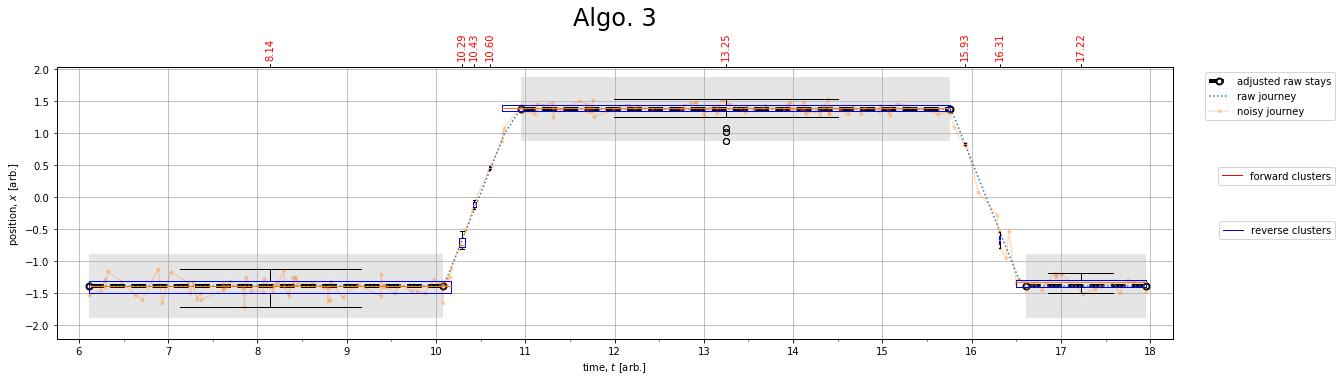

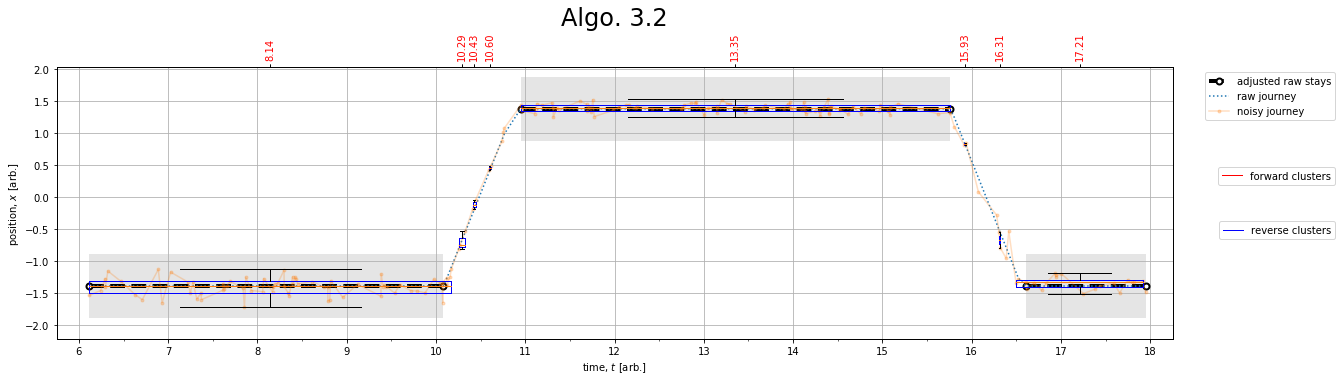

In [60]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3_2, switch_indices(clusters_3_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 3.2", fontsize=24);

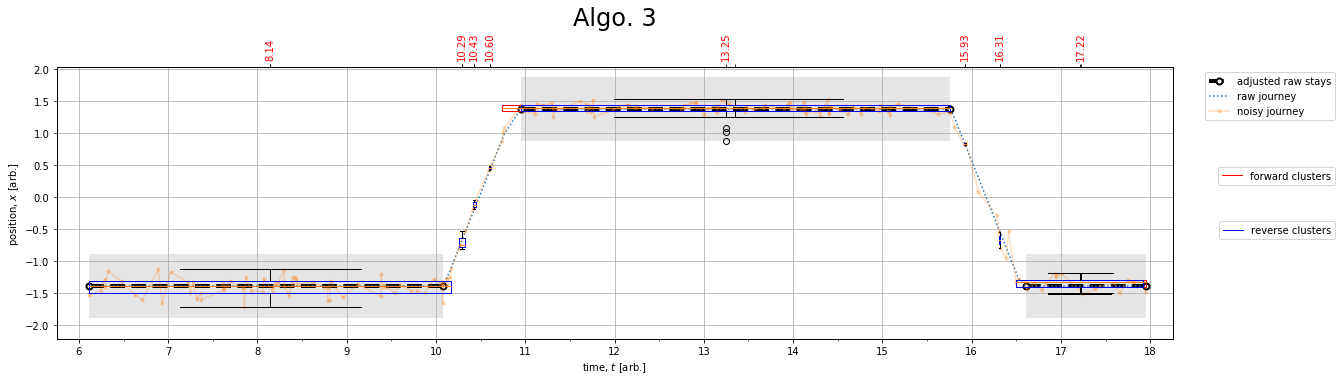

In [38]:
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Algo. 3", fontsize=24);